<a href="https://colab.research.google.com/github/raplima/2020_cores_auto/blob/master/scripts/experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install and download


In [ ]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

###############################
# download, decompress the data
!gdown https://drive.google.com/uc?id=1LJfHTdmPC_o-b_5dI2uVdhU5_FKGpBTJ
!unzip cores.zip > /dev/null

# download class json from github
!wget https://raw.githubusercontent.com/raplima/2020_cores_auto/master/data/classes.json
!mv classes.json cores

# download other local functions
!wget https://raw.githubusercontent.com/raplima/2020_cores_auto/master/scripts/data_loading.py
!wget https://raw.githubusercontent.com/raplima/2020_cores_auto/master/scripts/train.py


In [1]:
# import necessary libraries:
import os
import json
from shutil import copy2

from sklearn.model_selection import KFold

import numpy as np
from detectron2.structures import BoxMode
import cv2
import random

from matplotlib import pyplot as plt

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
from detectron2.config import get_cfg

# to train
from detectron2.engine import DefaultTrainer

# to evaluate
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# local functions
from data_loading import get_data_dicts

In [12]:
def plot_res (cfg, samp, im, outputs, patch_dict):
    im = cv2.imread(samp['file_name'])

    fig, ax = plt.subplots(ncols=3, figsize=(10,7))
    ax[0].imshow(im)
    ax[1].imshow(im)
    ax[2].imshow(im)

    ax[0].set_axis_off()
    ax[1].set_axis_off()
    ax[2].set_axis_off()

    ax[0].set_title('Input image')
    ax[1].set_title('Interpretation')
    ax[2].set_title('Prediction')

    # add letters:
    for ii, l in enumerate('ABC'):
        ax[ii].text(0, 0,
                    s=l, 
                    bbox=dict(facecolor='white', alpha=1), 
                    ha='left', va='bottom', size=14)
        
    # add colors:
    jj = 200
    for k in patch_dict:
        ax[2].text(im.shape[1], jj,
                    s=k, 
                    bbox=dict(facecolor=patch_dict[k]['color'], alpha=0.7), 
                    ha='left', va='bottom', size=14)
        jj += 500


    for annot in samp['annotations']:
        # select the x and y segmentation points
        segx = annot['segmentation'][0][0::2]
        segy = annot['segmentation'][0][1::2]
        p = ax[1].fill(segx, segy, patch_dict[thing_classes[annot['category_id']]]['color'], alpha=0.8)


    for ii in range(len(outputs['instances'])):
        # select the x and y segmentation points
        if outputs['instances'].scores[ii].item() > cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST:
            mask = np.array(outputs['instances'].pred_masks[ii].tolist())
            contours, hierarchy = cv2.findContours(mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
            c = np.array([[v[0][0], v[0][1]] for v in contours[0]])

            segx=c[:,0]
            segy=c[:,1]
            p = ax[2].fill(segx, segy, 
                           patch_dict[thing_classes[outputs['instances'].pred_classes[ii].item()]]['color'], 
                           alpha=0.8)
    return fig

In [3]:
# setup files
data_dir = 'cores'
dataset_tag = 'cores'

# read the classes dictionary
json_file = os.path.join(data_dir, "classes.json")
with open(json_file) as f:
    classes = json.load(f)

# setup color for now
patch_dict = {"skel_WkstPkst": {'color': '#73C6B6', 'hatch': 'O'},
               "lam_Sltst": {'color': '#F5B041', 'hatch': '-'},  
               "bio_Sltst": {'color': '#2E4053', 'hatch': '*'}, 
               "strless_SltstSst": {'color': '#F5CBA7', 'hatch': ' '},
               "brec_Cht": {'color': '#CCD1D1', 'hatch': '.'}
              }

# save a list with same format as function and metadata:
thing_classes = sorted([it for _, it in classes.items()])

# read main json file
json_file = os.path.join(data_dir, "vanhorn_hawkins_payne_musselman_final_json.json")

# lump classes:
# Read in the file
with open(json_file, 'r') as file :
  filedata = file.read()
# Replace the target string
for c_old, c_replace in [('glauconitic_siltstone/sandsstone', 'laminated_siltstone'), 
                         ('crosslaminated_siltstone', 'laminated_siltstone')]:
    filedata = filedata.replace(c_old, c_replace)

# Write the file out again
with open(json_file, 'w') as file:
  file.write(filedata)

# finally read in as dictionary:
with open(json_file) as f:
    main_json = json.load(f)

# save the dictionary keys:
k = list(main_json.keys())
# create kfold
kf = KFold(n_splits=5, random_state=0, shuffle=True)

# split the dictionary into n_splits train/test:
for fold_idx, [train_index, test_index] in enumerate(kf.split(k)):
    print(f'Saving fold {fold_idx} json dictionary')
    for d, indexes in zip(["train", "val"], [train_index, test_index]):
        tag = f'{dataset_tag}_fold_{fold_idx}_{d}'
        split_dict = {}
        for idx in indexes:
            split_dict[str(idx)] = main_json[k[idx]]
        # save to file:
        with open(os.path.join(data_dir, f"{tag}.json"), 'w') as f:
            json.dump(split_dict, f)

Saving fold 0 json dictionary
Saving fold 1 json dictionary
Saving fold 2 json dictionary
Saving fold 3 json dictionary
Saving fold 4 json dictionary


In [ ]:
#!python train.py --data_dir 'cores' --dataset_tag 'cores' --fold_idx '0'

In [4]:
#  loop over splits
for fold_idx in range(kf.get_n_splits()):
    print(f'setting fold {fold_idx}')
    for d in ["train", "val"]:
        tag = f'{dataset_tag}_fold_{fold_idx}_'
        # don't use fully f strings for register, it merges 'train' and 'val'
        print(f'\t {tag}' + d)
        DatasetCatalog.register(tag+d, lambda d=d: get_data_dicts(data_dir, tag + d + '.json'))
        MetadataCatalog.get(tag+d).set(thing_classes=sorted([it for _, it in classes.items()]))

print('ok')

setting fold 0
	 cores_fold_0_train
	 cores_fold_0_val
setting fold 1
	 cores_fold_1_train
	 cores_fold_1_val
setting fold 2
	 cores_fold_2_train
	 cores_fold_2_val
setting fold 3
	 cores_fold_3_train
	 cores_fold_3_val
setting fold 4
	 cores_fold_4_train
	 cores_fold_4_val
ok


cores_fold_4_train


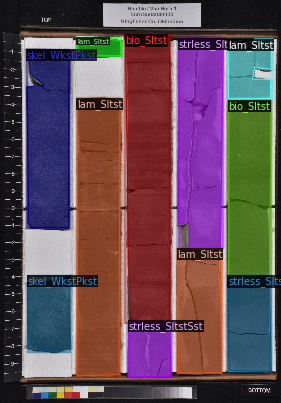

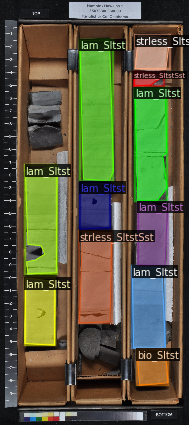

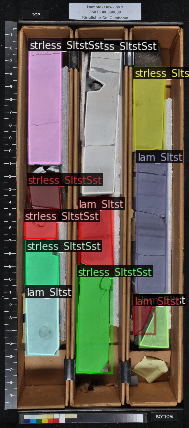

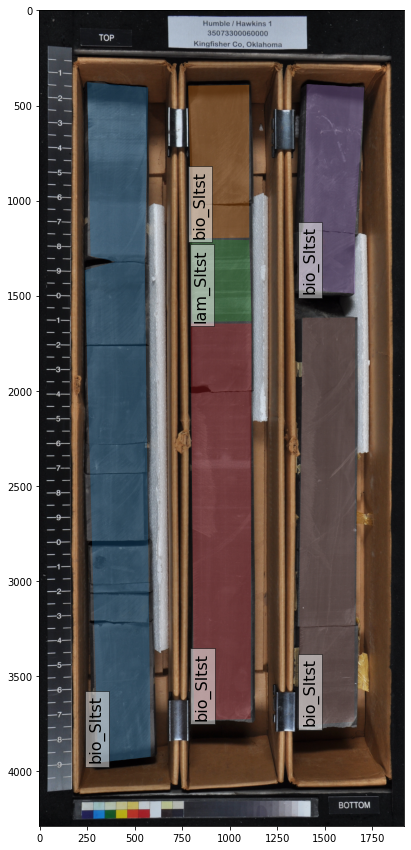

In [5]:
tag = f'{dataset_tag}_fold_{fold_idx}_'
d = 'train'
print(tag+d)
dataset_dicts = get_data_dicts(data_dir, tag + d + '.json')

samp = random.sample(dataset_dicts, 1)[0]

img = np.rot90(plt.imread(samp["file_name"]), -1)

fig, ax = plt.subplots(1, figsize=(12,15))
ax.imshow(img)

for annot in samp['annotations']:
    # select the x and y segmentation points
    segx = annot['segmentation'][0][0::2]
    segy = annot['segmentation'][0][1::2]
    ax.fill(segx, segy, alpha=0.3)
    ax.text(np.min(segx)+20, np.max(segy), 
        s=thing_classes[annot['category_id']], 
        bbox=dict(facecolor='white', alpha=0.5), 
        rotation=90, ha='left', va='bottom', size=16)
    
# check how detectron sees it
from detectron2.utils.visualizer import Visualizer
from google.colab.patches import cv2_imshow

for samp in random.sample(dataset_dicts, 3):
    img = cv2.imread(samp["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get(tag+d), scale=0.1)
    vis = visualizer.draw_dataset_dict(samp)
    cv2_imshow(vis.get_image()[:, :, ::-1])    

Thu Jul  2 18:04:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

model_final_f10217.pkl: 178MB [00:16, 11.1MB/s]                           
Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (6, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (6,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (20, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (20,) in the model!
Unable to load 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (5, 256, 1, 1) in the model!
Unable to load 'roi_heads.mask_head.predictor.bias' to the model due to incompatible shapes: (80,) in the checkpoint but (5,) in the model!


[07/02 18:05:00 d2.engine.train_loop]: Starting training from iteration 0
[07/02 18:06:35 d2.utils.events]:  eta: 0:44:24  iter: 19  total_loss: 3.673  loss_cls: 2.008  loss_box_reg: 0.321  loss_mask: 0.694  loss_rpn_cls: 0.439  loss_rpn_loc: 0.211  time: 4.6204  data_time: 2.0441  lr: 0.000020  max_mem: 8435M
[07/02 18:08:10 d2.utils.events]:  eta: 0:43:31  iter: 39  total_loss: 2.745  loss_cls: 1.322  loss_box_reg: 0.389  loss_mask: 0.671  loss_rpn_cls: 0.152  loss_rpn_loc: 0.165  time: 4.6709  data_time: 1.8894  lr: 0.000040  max_mem: 8436M
[07/02 18:09:44 d2.utils.events]:  eta: 0:42:32  iter: 59  total_loss: 2.005  loss_cls: 0.702  loss_box_reg: 0.424  loss_mask: 0.615  loss_rpn_cls: 0.080  loss_rpn_loc: 0.147  time: 4.6909  data_time: 1.8446  lr: 0.000060  max_mem: 8436M
[07/02 18:11:22 d2.utils.events]:  eta: 0:41:23  iter: 79  total_loss: 1.785  loss_cls: 0.574  loss_box_reg: 0.469  loss_mask: 0.541  loss_rpn_cls: 0.047  loss_rpn_loc: 0.146  time: 4.7346  data_time: 1.9146  lr:

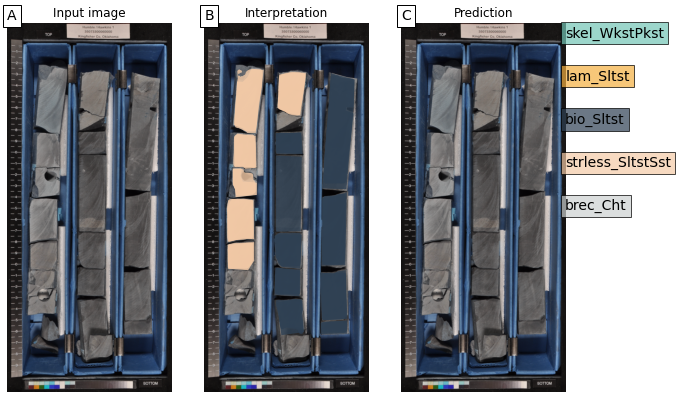

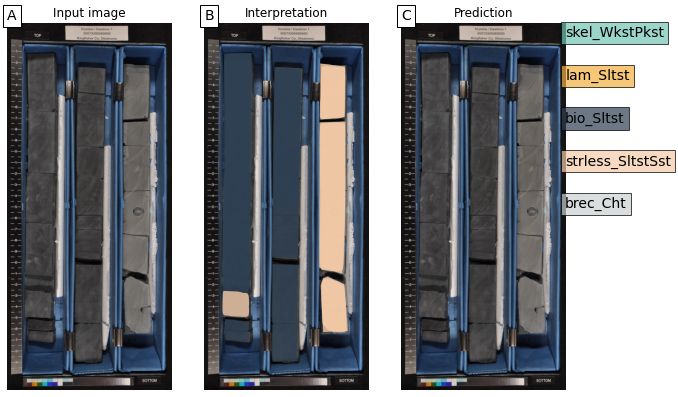

In [6]:
# setup evaluator for the trainer
class CocoTrainer(DefaultTrainer):
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_dir='training_coco'):
    if output_dir is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_dir = "coco_eval"
    return COCOEvaluator(dataset_name, cfg, False, output_dir)

# print GPU information
!nvidia-smi

for fold_idx in range(kf.get_n_splits()):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.DATASETS.TRAIN = (f"{dataset_tag}_fold_{fold_idx}_train",)
    cfg.DATASETS.TEST = (f"{dataset_tag}_fold_{fold_idx}_train", f"{dataset_tag}_fold_{fold_idx}_val",)
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.INPUT.MAX_SIZE_TRAIN = 1000
    cfg.INPUT.MAX_SIZE_TEST = 1000

    # Let training initialize from model zoo
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  

    cfg.SOLVER.IMS_PER_BATCH = 8
    cfg.SOLVER.BASE_LR = 0.001  
    cfg.SOLVER.MAX_ITER = 600    
    cfg.TEST.EVAL_PERIOD = 200

    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512  
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)   # number of classes

    cfg.OUTPUT_DIR = f'output_fold_{fold_idx}'
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    trainer = CocoTrainer(cfg) 
    trainer.resume_or_load(resume=False)

    # train:
    trainer.train()

    # copy the weights 
#    copy2(os.path.join(cfg.OUTPUT_DIR, 'model_final.pth'), 
#            os.path.join(cfg.OUTPUT_DIR, f'model_fold_{fold_idx}.pth'))    

    # evaluate
    #cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, f'model_fold_{fold_idx}.pth')
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, 'model_final.pth')
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model

    predictor = DefaultPredictor(cfg)

    for d in ['train', 'val']:
        print(f'\n\n**Starting {d} eval**')
        cfg.DATASETS.TEST = (f"{dataset_tag}_fold_{fold_idx}_{d}",)
        evaluator = COCOEvaluator(f"{dataset_tag}_fold_{fold_idx}_{d}", cfg, False, output_dir=f"./coco/")
        val_loader = build_detection_test_loader(cfg, f"{dataset_tag}_fold_{fold_idx}_{d}")
        metrics = inference_on_dataset(trainer.model, val_loader, evaluator)
        with open(os.path.join(cfg.OUTPUT_DIR, f"cocoeval_{d}_{fold_idx}.json"), 'w') as f:
            json.dump(metrics, f)
        
  # save one example:
        samp = random.sample(DatasetCatalog.get(f"{dataset_tag}_fold_{fold_idx}_{d}"), 1)[0]
        print(f"randomly selected {samp['file_name']}")
        im = cv2.imread(samp['file_name'])
        outputs = predictor(im)
        fig = plot_res(cfg, samp, im, outputs, patch_dict)
        fig.tight_layout
        fig.savefig(os.path.join(cfg.OUTPUT_DIR, f"{dataset_tag}_fold_{fold_idx}_{d}_{samp['file_name']}.pdf".replace('/','-')), dpi=1000)

    break

In [ ]:
 for d in ['train', 'val']:
        print(f'\n\n**Starting {d} eval**')
        cfg.DATASETS.TEST = (f"{dataset_tag}_fold_{fold_idx}_{d}",)
        evaluator = COCOEvaluator(f"{dataset_tag}_fold_{fold_idx}_{d}", cfg, False, output_dir=f"./coco/")
        val_loader = build_detection_test_loader(cfg, f"{dataset_tag}_fold_{fold_idx}_{d}")
        metrics = inference_on_dataset(trainer.model, val_loader, evaluator)
        with open(os.path.join(cfg.OUTPUT_DIR, f"cocoeval_{d}_{fold_idx}.json"), 'w') as f:
            json.dump(metrics, f)
        
  # save one example:
        samp = random.sample(DatasetCatalog.get(f"{dataset_tag}_fold_{fold_idx}_{d}"), 1)[0]
        print(f"randomly selected {samp['file_name']}")
        im = cv2.imread(samp['file_name'])
        outputs = predictor(im)
        fig = plot_res(cfg, samp, im, outputs, patch_dict)
        fig.tight_layout
        fig.savefig(os.path.join(cfg.OUTPUT_DIR, f"{dataset_tag}_fold_{fold_idx}_{d}_{samp['file_name']}.pdf".replace('/','-')), dpi=1000)

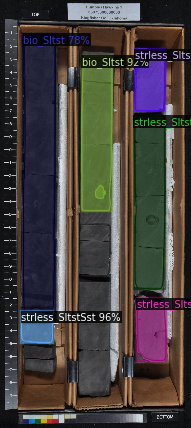

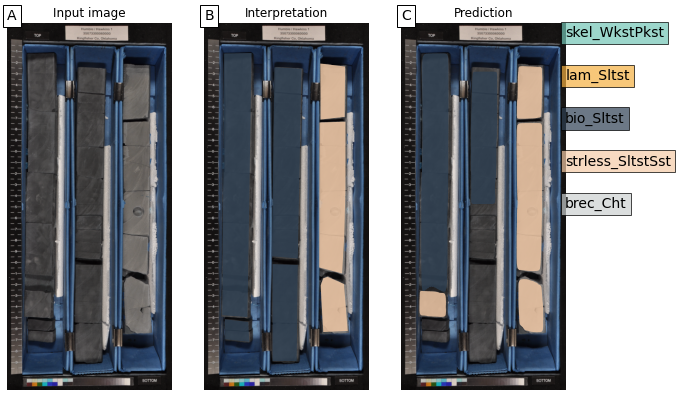

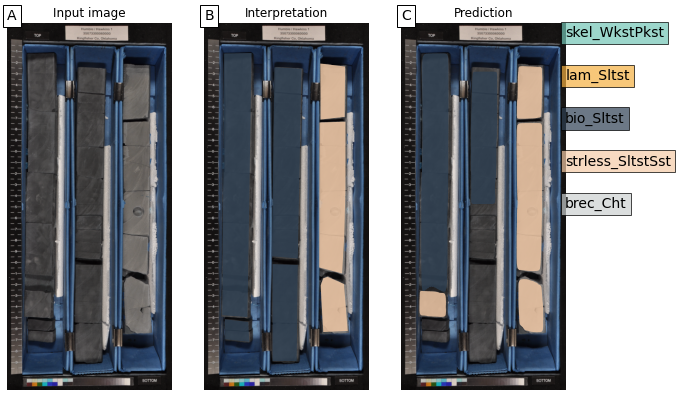

In [13]:
from detectron2.utils.visualizer import ColorMode
v = Visualizer(im[:, :, ::-1],
                metadata=MetadataCatalog.get(f"{dataset_tag}_fold_{fold_idx}_{d}"), 
                scale=0.1, 
                instance_mode=ColorMode.SEGMENTATION   # remove the colors of unsegmented pixels
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])
plot_res(cfg, samp, im, outputs, patch_dict)

In [8]:
for ii in range(len(outputs['instances'])):
        # select the x and y segmentation points
        if outputs['instances'].scores[ii].item() > cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST:
          print(patch_dict[thing_classes[outputs['instances'].pred_classes[ii].item()]], thing_classes[outputs['instances'].pred_classes[ii].item()])

{'color': '#F5CBA7', 'hatch': ' '} strless_SltstSst
{'color': '#F5CBA7', 'hatch': ' '} strless_SltstSst
{'color': '#2E4053', 'hatch': '*'} bio_Sltst
{'color': '#2E4053', 'hatch': '*'} bio_Sltst
{'color': '#F5CBA7', 'hatch': ' '} strless_SltstSst
{'color': '#F5CBA7', 'hatch': ' '} strless_SltstSst


In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output_fold_0
# images can be exported as SVG for further edits before publication

randomly selected cores/Box 5  Depths 8935-8945 (Dry).JPG
output_fold_0/cores_fold_0_val_cores-Box 5  Depths 8935-8945 (Dry).JPG.pdf


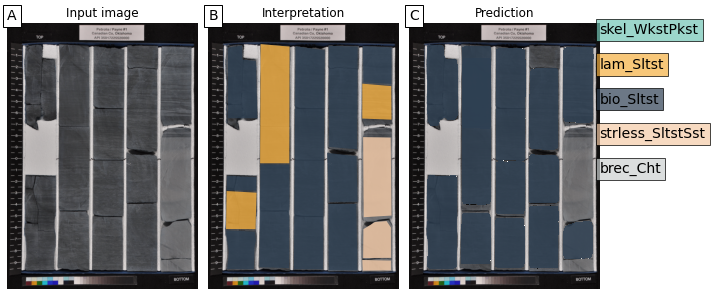

In [ ]:
patch_dict = {"skel_WkstPkst": {'color': '#73C6B6', 'hatch': 'O'},
               "lam_Sltst": {'color': '#F5B041', 'hatch': '-'},  
               "bio_Sltst": {'color': '#2E4053', 'hatch': '*'}, 
               "strless_SltstSst": {'color': '#F5CBA7', 'hatch': ' '},
               "brec_Cht": {'color': '#CCD1D1', 'hatch': '.'}
              }

samp = random.sample(DatasetCatalog.get(f"{dataset_tag}_fold_{fold_idx}_{d}"), 1)[0]
print(f"randomly selected {samp['file_name']}")
outputs = predictor(im)

im = cv2.imread(samp['file_name'])

fig, ax = plt.subplots(ncols=3, figsize=(10,7))
ax[0].imshow(im)
ax[1].imshow(im)
ax[2].imshow(im)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

ax[0].set_title('Input image')
ax[1].set_title('Interpretation')
ax[2].set_title('Prediction')

# add letters:
for ii, l in enumerate('ABC'):
    ax[ii].text(0, 0,
                s=l, 
                bbox=dict(facecolor='white', alpha=1), 
                 ha='left', va='bottom', size=14)
    
# add colors:
jj = 200
for k in patch_dict:
    ax[2].text(im.shape[1], jj,
                s=k, 
                bbox=dict(facecolor=patch_dict[k]['color'], alpha=0.7), 
                ha='left', va='bottom', size=14)
    jj += 500


for annot in samp['annotations']:
    # select the x and y segmentation points
    segx = annot['segmentation'][0][0::2]
    segy = annot['segmentation'][0][1::2]
    p = ax[1].fill(segx, segy, patch_dict[thing_classes[annot['category_id']]]['color'], alpha=0.8)

# work-around to set imshow colors
cmap = plt.cm.gray
cmap.set_under('red', alpha=0.)

for ii in range(len(outputs['instances'])):
    # select the x and y segmentation points
    if outputs['instances'].scores[ii].item() > cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST:
        cmap.set_over(patch_dict[thing_classes[outputs['instances'].pred_classes[ii].item()]]['color'], 
                      alpha=0.8)
        ax[2].imshow(np.array(outputs['instances'].pred_masks[ii].tolist()), 
                     clim=[0.1, 0.11], cmap=cmap)

fig.tight_layout()

fig.savefig(os.path.join(cfg.OUTPUT_DIR, f"{dataset_tag}_fold_{fold_idx}_{d}_{samp['file_name']}.pdf".replace('/','-')), dpi=1000)
print(os.path.join(cfg.OUTPUT_DIR, f"{dataset_tag}_fold_{fold_idx}_{d}_{samp['file_name']}.pdf".replace('/','-')))

In [ ]:
#! zip -r results.zip out* 
#!cp results.zip '/content/gdrive/My Drive'
!ls -lth output_fold_0

total 670M
-rw-r--r-- 1 root root  606 Jun 30 20:30 cocoeval_val_0.json
-rw-r--r-- 1 root root 4.1K Jun 30 20:22 events.out.tfevents.1593547982.79d7ea321c0d.1554.0
-rw-r--r-- 1 root root  19K Jun 30 20:22 metrics.json
-rw-r--r-- 1 root root   15 Jun 30 20:14 last_checkpoint
-rw-r--r-- 1 root root 335M Jun 30 20:14 model_final.pth
-rw-r--r-- 1 root root 335M Jun 30 20:14 model_fold_0.pth
-rw-r--r-- 1 root root  24K Jun 30 20:08 events.out.tfevents.1593545166.79d7ea321c0d.710.0


In [ ]:
! rm -r out*
! rm -r coco*

rm: cannot remove 'output/': No such file or directory
rm: cannot remove 'coco*': No such file or directory


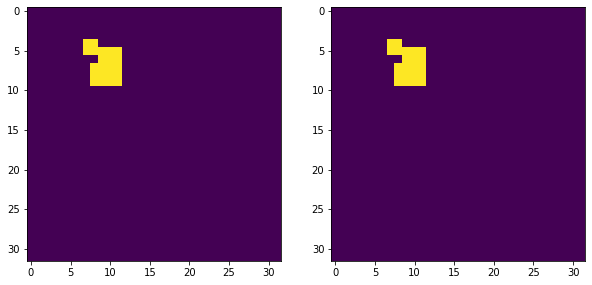

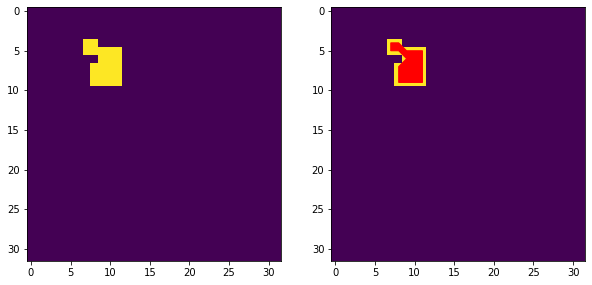

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

mask = np.zeros((32, 32))
mask[4:6, 7:9] = 1
mask[5:7, 9:12] = 1
mask[7:10, 8:12] = 1
fig, ax = plt.subplots(ncols=2, figsize=(10,10))
ax[0].imshow(mask)
ax[1].imshow(mask)

import numpy as np
import cv2 as cv
contours, hierarchy = cv.findContours(mask.astype(np.uint8), cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
c = np.array([[v[0][0], v[0][1]] for v in contours[0]])
fig, ax = plt.subplots(ncols=2, figsize=(10,10))
ax[0].imshow(mask)
ax[1].imshow(mask)
segx=c[:,0]
segy=c[:,1]
ax[1].fill(segx, segy, c='red')

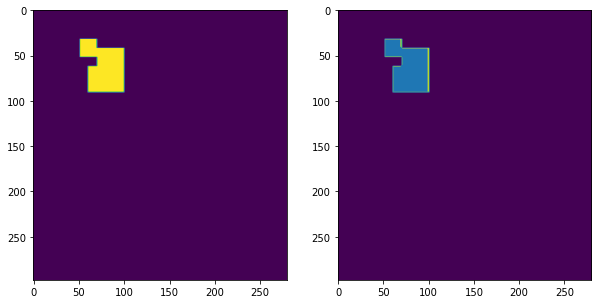

In [ ]:
import numpy as np
import cv2 as cv
im = cv.imread('test.jpg')
imgray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(imgray, 127, 255, 0)
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
c = np.array([[v[0][0], v[0][1]] for v in contours[0]])
fig, ax = plt.subplots(ncols=2, figsize=(10,10))
ax[0].imshow(imgray)
ax[1].imshow(imgray)
segx=c[:,0]
segy=c[:,1]
ax[1].fill(segx, segy)

In [9]:
for ii in range(len(outputs['instances'])):
        # select the x and y segmentation points
        if outputs['instances'].scores[ii].item() > cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST:
            mask = np.array(outputs['instances'].pred_masks[ii].tolist())
            contours, hierarchy = cv2.findContours(mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
            c = np.array([[v[0][0], v[0][1]] for v in contours[0]])

            segx=c[:,0]
            segy=c[:,1]

In [11]:
segx

array([1407, 1406, 1405, ..., 1410, 1409, 1408], dtype=int32)